In [19]:
# Imports
from astropy.time import Time
from astropy.coordinates import AltAz, Angle, EarthLocation, ICRS, SkyCoord
from astropy import units as u
from cartopy import config
import cartopy.crs as ccrs
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import os
from scipy.optimize import minimize_scalar

# Matplotlib settings
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8.0)
matplotlib.rcParams['xtick.labelsize'] = 24.0
matplotlib.rcParams['ytick.labelsize'] = 24.0
matplotlib.rcParams['axes.titlesize'] = 27.0
matplotlib.rcParams['axes.labelsize'] = 27.0
matplotlib.rcParams['legend.fontsize'] = 24.0
matplotlib.rcParams['font.serif'] = ['Computer Modern', 'Times New Roman']
matplotlib.rcParams['font.family'] = ['serif', 'STIXGeneral']
matplotlib.rcParams['legend.frameon'] = True
import matplotlib.pyplot as plt

# Input: time, ra, dec
As an example, use the time and location of GRB 221009A

In [2]:
# UTC time of detection
obstime = Time({'year': 2022, 'month': 10, 'day': 9,
    'hour': 13, 'minute': 16, 'second': 59.0}, scale='utc')

# Location of astrophysical source
ra = 288.2652 * u.deg
dec = 19.7735 * u.deg

# Output: optimal latitude and longitude
Approximately where on Earth do you need to stand (lat, lon) for GRB 221009A to be directly overhead?

We know from physical intuition that the latitude should equal the declination, so we only need to solve for longitude.

In [3]:
# Set latitude equal to declination
opt_lat = dec.value

In [4]:
# Find optimal longitude

def get_zenith(lon, lat, ra, dec, obstime=obstime):
    """
    Record the zenith angle at a given latitude and longitude,
    given a right ascension, declination, and UTC time
    """
    
    # Convert to EarthLocation object, assumign height equivalent to WGS84 ellipsoid
    # Returns loc, which is x,y,z in meters as geocentric coordinates
    loc = EarthLocation.from_geodetic(lat=lat, lon=lon)
    
    # Convert sky location into SkyCoord object
    sky = SkyCoord(frame=ICRS, ra=ra, dec=dec, 
        obstime=obstime, location=loc)
    
    # Convert to altitude and azimuthal angles
    altaz = sky.transform_to(AltAz)
    
    # Report zenith angle
    return altaz.zen.degree


opt_lon = minimize_scalar(get_zenith, args=(opt_lat, ra, dec)).x


In [5]:
# Print out optimal coordinates
def label_lat_lon(lat, lon):
    """
    String formatter for latitude and longitude
    """
    if lat >= 0:
        label = f'{lat:.2f}N,'
    else:
        label = f'{lat:.2f}S'
    if lon > 180:
        label += f' {360 - lon:.2f}W'
    else:
        label += f' {lon:.2f}E'
    
    return label


print(f'Optimal Location: {label_lat_lon(opt_lat, opt_lon)}')

Optimal Location: 19.77N, 71.13E


# Data visualization
Make a nice plot of zenith angle across the Earth

## To do:
- Try out other projections
- Get colorbar to show up on the plot
- Fix colorbar between 0 and 180 degrees

In [9]:
# Get latitudes and longitudes in a format that works well with cartopy
fname = os.path.join(config["repo_data_dir"],
                     'netcdf', 'HadISST1_SST_update.nc'
                     )

dataset = netcdf_dataset(fname)
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

# Trim and convert arrays
lons = np.insert(np.append(180 + lons[::10], 360), 0, 0)
lats = lats[::10]


# Set up coordinate grid
lon2d, lat2d = np.meshgrid(lons, lats)
Z = np.zeros_like(lon2d)

# Compute zenith angles for each latitude and longitude
for lat_idx, lat in enumerate(lats):
    Z[lat_idx] = get_zenith(lons, lat, ra, dec)

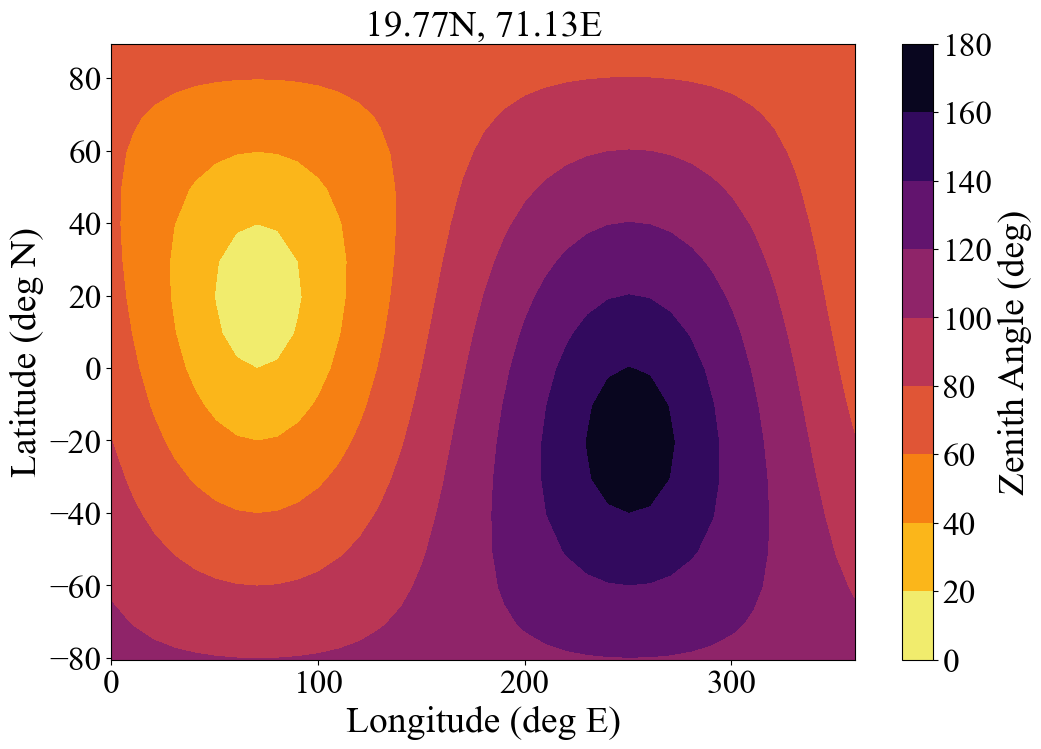

In [31]:
# 2D plot
fig, ax = plt.subplots()
contour = ax.contourf(lon2d, lat2d, Z, 
    levels=np.linspace(0, 180, 10), cmap='inferno_r')


# Plot optimal point
ax.scatter(opt_lon, opt_lat, color='magenta', edgecolor='k',
    marker='*', s=400, zorder=0)

# Labels
ax.set_xlabel('Longitude (deg E)')
ax.set_ylabel('Latitude (deg N)')
ax.set_title(label_lat_lon(opt_lat, opt_lon))
plt.colorbar(contour, label='Zenith Angle (deg)')

plt.show()

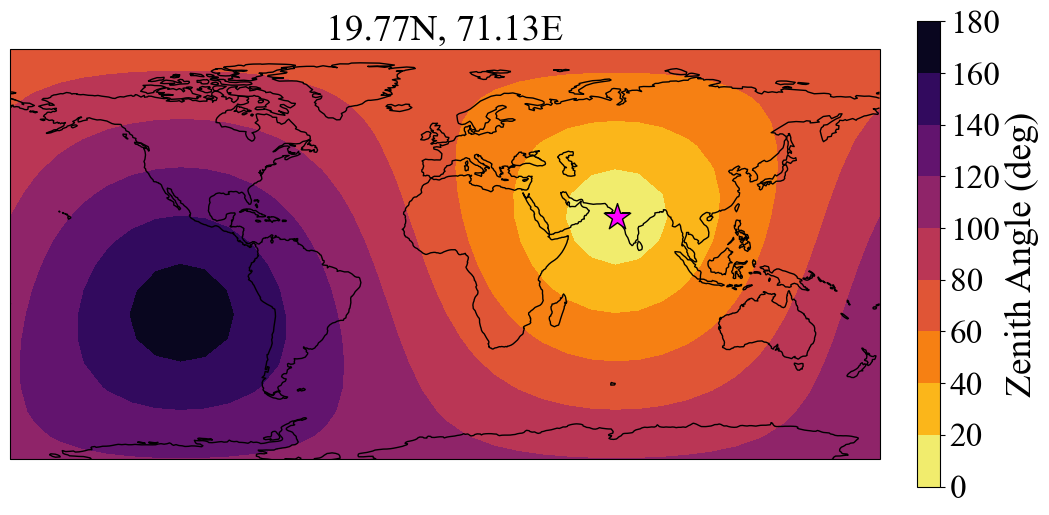

In [32]:
# Map
ax = plt.axes(projection=ccrs.PlateCarree())


contour = ax.contourf(lon2d, lat2d, Z, levels=np.linspace(0, 180, 10),
             transform=ccrs.PlateCarree(), cmap='inferno_r')

# Plot optimal point
ax.scatter(opt_lon, opt_lat, color='magenta', edgecolor='k',
    marker='*', s=400, zorder=10)

# Labels
ax.set_title(label_lat_lon(opt_lat, opt_lon))

# Add coastlines
ax.coastlines()

# Set up colorbar
plt.colorbar(contour, label='Zenith Angle (deg)', fraction=0.025, pad=0.04)

plt.show()

# Try different projections

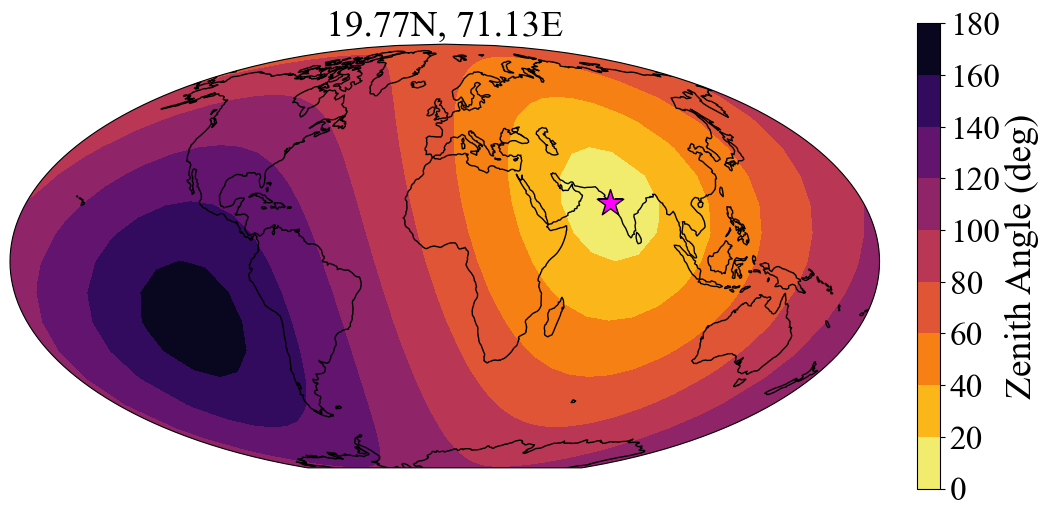

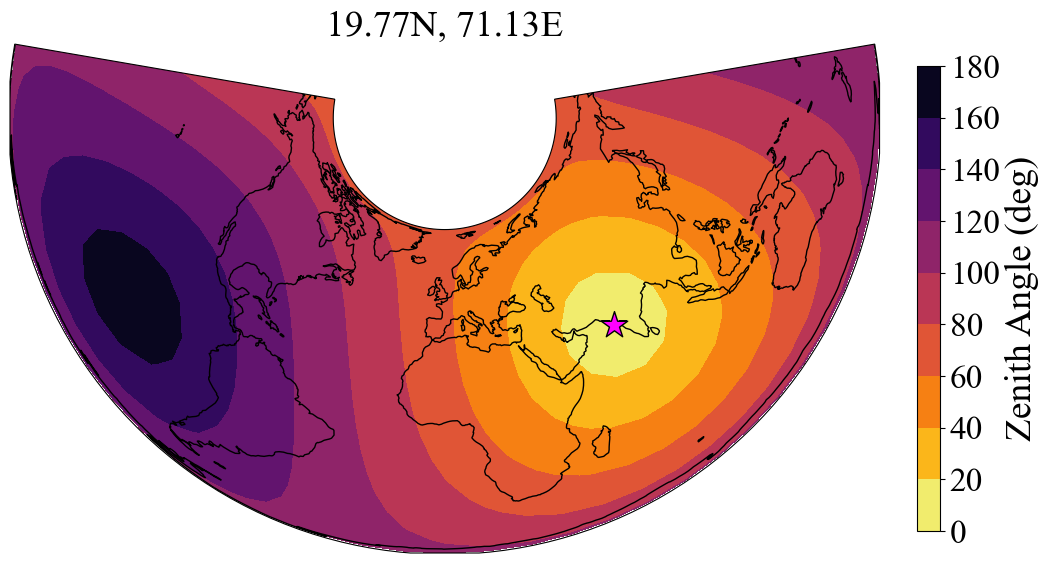

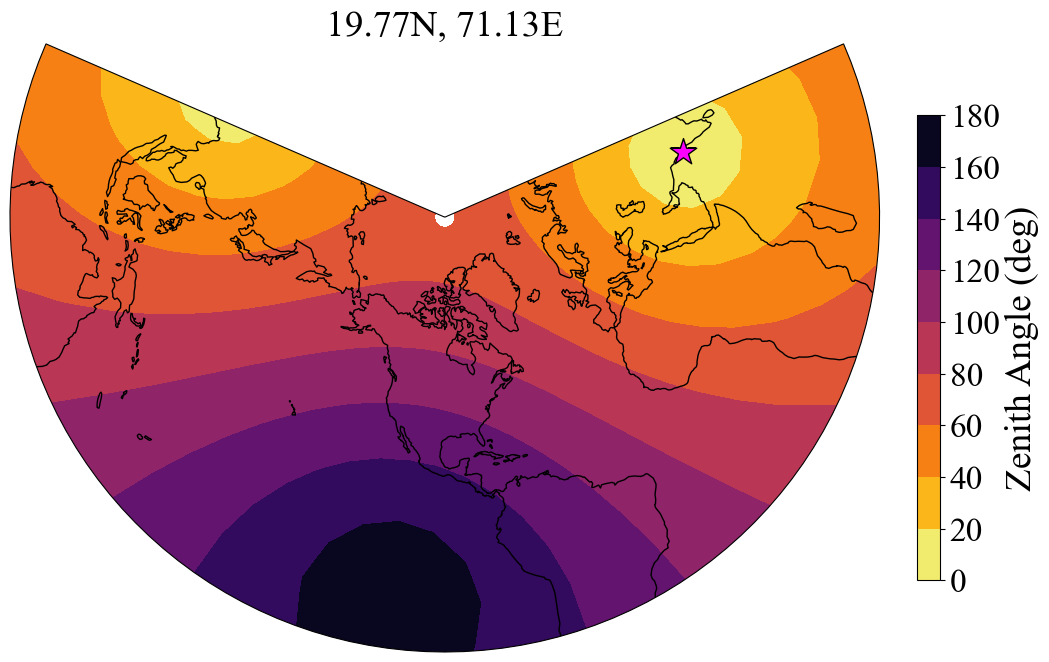

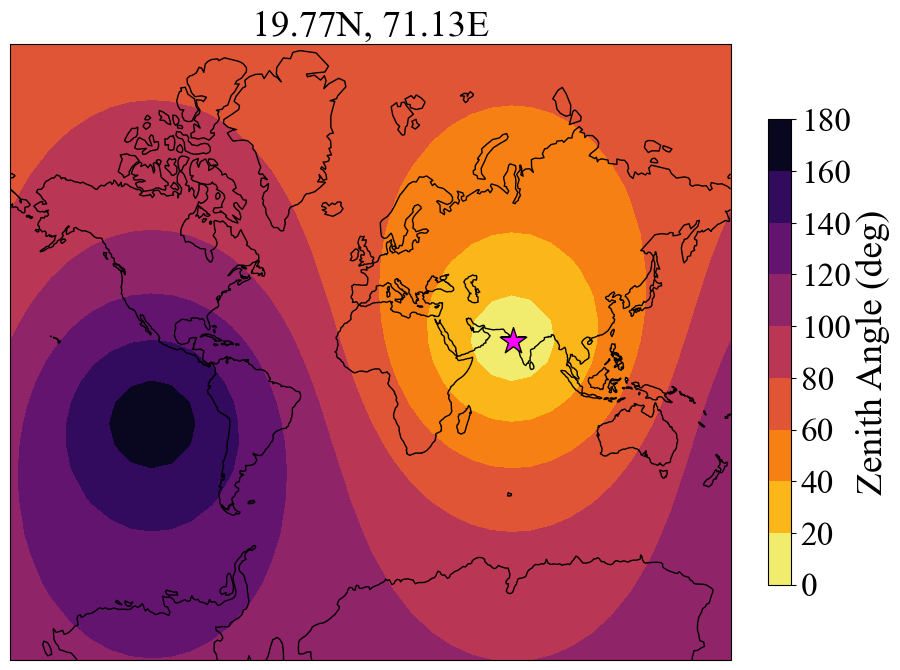

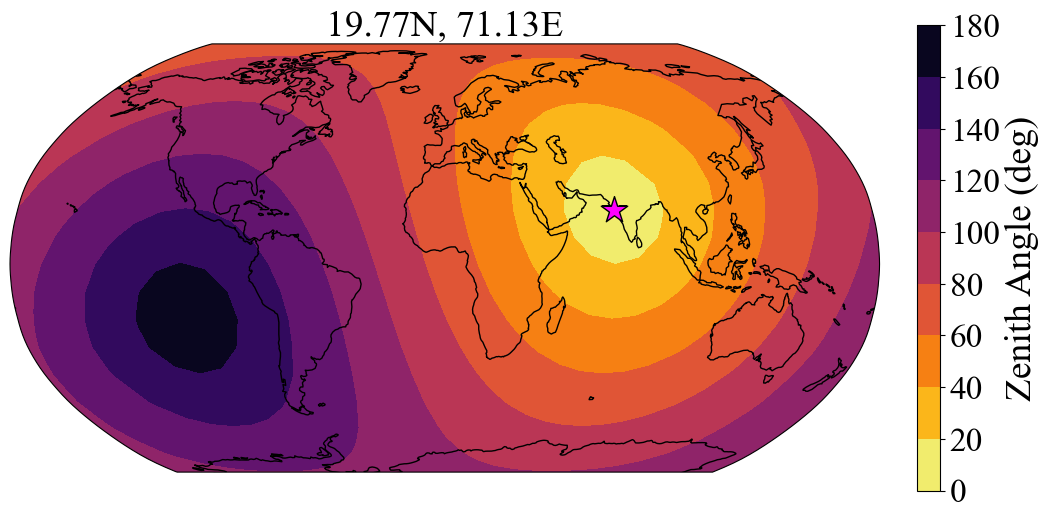

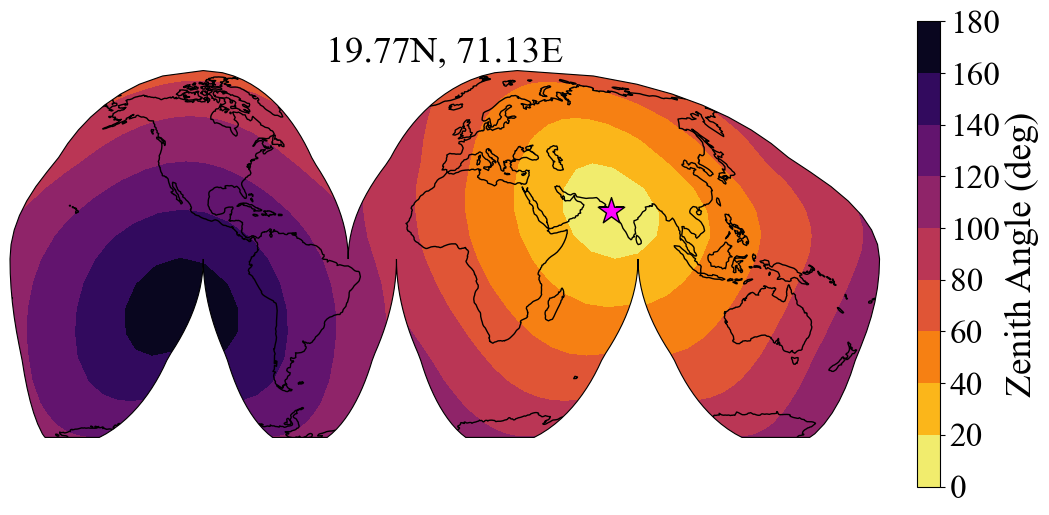

In [44]:
for proj in [ccrs.Mollweide(), ccrs.AlbersEqualArea(),
    ccrs.LambertConformal(), ccrs.Mercator(), ccrs.Robinson(), 
    ccrs.InterruptedGoodeHomolosine()]:
    
    ax = plt.axes(projection=proj)


    contour = ax.contourf(lon2d, lat2d, Z, levels=np.linspace(0, 180, 10),
                 transform=ccrs.PlateCarree(), cmap='inferno_r')

    # Plot optimal point
    ax.scatter(opt_lon, opt_lat, color='magenta', edgecolor='k',
        marker='*', s=400, zorder=10, transform=ccrs.PlateCarree())

    # Labels
    ax.set_title(label_lat_lon(opt_lat, opt_lon))

    # Add coastlines
    ax.coastlines()

    # Set up colorbar
    plt.colorbar(contour, label='Zenith Angle (deg)', fraction=0.025, pad=0.04)

    plt.show()